In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import lightgbm as lgb
from sklearn.model_selection import KFold
from imblearn.metrics import  geometric_mean_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve, precision_score 
from sklearn.metrics import recall_score, average_precision_score, auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [2]:
credit_df = pd.read_csv('/content/creditfraud.csv',  delimiter=',')

credit_df



Time         V1         V2  ...       V28  Amount  Class
0            0.0  -1.359807  -0.072781  ... -0.021053  149.62      0
1            0.0   1.191857   0.266151  ...  0.014724    2.69      0
2            1.0  -1.358354  -1.340163  ... -0.059752  378.66      0
3            1.0  -0.966272  -0.185226  ...  0.061458  123.50      0
4            2.0  -1.158233   0.877737  ...  0.215153   69.99      0
...          ...        ...        ...  ...       ...     ...    ...
284802  172786.0 -11.881118  10.071785  ...  0.823731    0.77      0
284803  172787.0  -0.732789  -0.055080  ... -0.053527   24.79      0
284804  172788.0   1.919565  -0.301254  ... -0.026561   67.88      0
284805  172788.0  -0.240440   0.530483  ...  0.104533   10.00      0
284806  172792.0  -0.533413  -0.189733  ...  0.013649  217.00      0

[284807 rows x 31 columns]

In [3]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


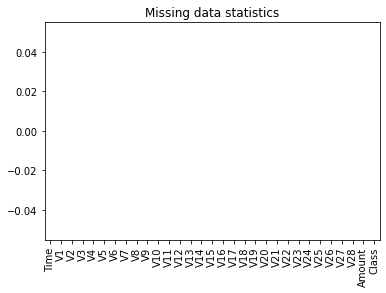

In [4]:
c = credit_df.isnull().sum()
plt.title("Missing data statistics")
c.plot(kind='bar')
print(c)

Count of Non-Fraud Transactions 284315
Count of Fraud Transactions 492


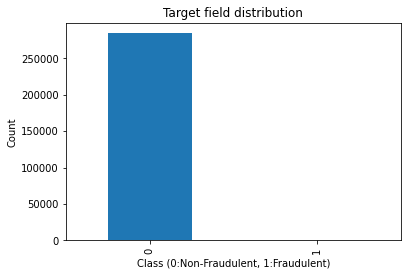

In [5]:
negative, positive = credit_df['Class'].value_counts()
print('Count of Non-Fraud Transactions', negative)
print('Count of Fraud Transactions', positive)
credit_df['Class'].value_counts().plot(kind='bar', title='Target field distribution')

plt.ylabel('Count')
plt.xlabel('Class (0:Non-Fraudulent, 1:Fraudulent)')
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = credit_df[['Amount','Time']]

credit_df[['Amount','Time']] = scaler.fit_transform(data)

credit_df

Time         V1         V2  ...       V28    Amount  Class
0      -1.996583  -1.359807  -0.072781  ... -0.021053  0.244964      0
1      -1.996583   1.191857   0.266151  ...  0.014724 -0.342475      0
2      -1.996562  -1.358354  -1.340163  ... -0.059752  1.160686      0
3      -1.996562  -0.966272  -0.185226  ...  0.061458  0.140534      0
4      -1.996541  -1.158233   0.877737  ...  0.215153 -0.073403      0
...          ...        ...        ...  ...       ...       ...    ...
284802  1.641931 -11.881118  10.071785  ...  0.823731 -0.350151      0
284803  1.641952  -0.732789  -0.055080  ... -0.053527 -0.254117      0
284804  1.641974   1.919565  -0.301254  ... -0.026561 -0.081839      0
284805  1.641974  -0.240440   0.530483  ...  0.104533 -0.313249      0
284806  1.642058  -0.533413  -0.189733  ...  0.013649  0.514355      0

[284807 rows x 31 columns]

In [7]:
pd.set_option('max_columns', None)

In [8]:
credit_df.groupby(credit_df['Class']).agg(['min', 'max'])

Time                  V1                   V2             \
            min       max       min       max        min        max   
Class                                                                 
0     -1.996583  1.642058 -56.40751  2.454930 -72.715728  18.902453   
1     -1.988034  1.590592 -30.55238  2.132386  -8.402154  22.057729   

              V3                  V4                     V5             \
             min       max       min        max         min        max   
Class                                                                    
0     -48.325589  9.382558 -5.683171  16.875344 -113.743307  34.801666   
1     -31.103685  2.250210 -1.313275  12.114672  -22.105532  11.095089   

              V6                    V7                     V8             \
             min        max        min         max        min        max   
Class                                                                      
0     -26.160506  73.301626 -31.764946  120.589494 -73.216718  18.709255   
1      -6.406267   6.474115 -43.557242    5.802537 -41.044261  20.007208   

              V9                   V10                  V11             \
             min        max        min        max       min        max   
Class                                                                    
0      -6.290730  15.594995 -14.741096  23.745136 -4.797473  10.002190   
1     -13.434066   3.353525 -24.588262   4.031435 -1.702228  12.018913   

             V12                 V13                  V14             \
             min       max       min       max        min        max   
Class                                                                  
0     -15.144988  7.848392 -5.791881  7.126883 -18.392091  10.526766   
1     -18.683715  1.375941 -3.127795  2.815440 -19.214325   3.442422   

            V15                  V16                   V17            \
            min       max        min        max        min       max   
Class                                                                  
0     -4.391307  8.877742 -10.115560  17.315112 -17.098444  9.253526   
1     -4.498945  2.471358 -14.129855   3.139656 -25.162799  6.739384   

            V18                 V19                  V20             \
            min       max       min       max        min        max   
Class                                                                 
0     -5.366660  5.041069 -7.213527  5.591971 -54.497720  39.420904   
1     -9.498746  3.790316 -3.681904  5.228342  -4.128186  11.059004   

             V21                   V22                   V23             \
             min        max        min        max        min        max   
Class                                                                     
0     -34.830382  22.614889 -10.933144  10.503090 -44.807735  22.528412   
1     -22.797604  27.202839  -8.887017   8.361985 -19.254328   5.466230   

            V24                  V25                 V26                  V27  \
            min       max        min       max       min       max        min   
Class                                                                           
0     -2.836627  4.584549 -10.295397  7.519589 -2.604551  3.517346 -22.565679   
1     -2.028024  1.091435  -4.781606  2.208209 -1.152671  2.745261  -7.263482   

                        V28               Amount              
             max        min        max       min         max  
Class                                                         
0      31.612198 -15.430084  33.847808 -0.353229  102.362243  
1       3.052358  -1.869290   1.779364 -0.353229    8.146182

In [9]:
x= credit_df.drop(['Class'], axis=1)

y = credit_df['Class']
x.shape


(284807, 30)

# AIS Algorithm functions

In [10]:
def initilization_of_population_featurebased(size,n_feat):
    population = []
    #chromosome = []
    for j in range(size): 
        chromosome = []    #chromosome type is list
        for i in range(n_feat):
            if i == 0:
                gene = round(random.uniform(-1.988034,1.590592),4)
            elif i == 1:
                gene =round(random.uniform(-30.55238,2.132386),4)
            elif i == 2:
                gene = round(random.uniform(2.132386,-8.402154),4)
            elif i == 3:
                gene = round(random.uniform(-31.103685,2.250210),4)
            elif i == 4:
                gene = round(random.uniform(-1.313275,12.114672),4)
            elif i == 5:
                gene = round(random.uniform(-22.105532,11.095089),4)
            elif i == 6:
                gene = round(random.uniform(-6.406267,6.474115),4)
            elif i == 7:
                gene =round(random.uniform(-43.557242,5.802537),4)
            elif i == 8:
                gene = round(random.uniform(-41.044261,20.007208),4)
            elif i == 9:
                gene = round(random.uniform(-13.434066,3.353525),4)
            elif i == 10:
                gene = round(random.uniform(-24.588262,4.031435),4)
            elif i == 11:
                gene = round(random.uniform(-1.702228,12.018913),4)
            elif i == 12:
                gene = round(random.uniform(-18.683715,1.375941),4)
            elif i == 13:
                gene = round(random.uniform(-3.127795,2.815440),2)
            elif i == 14:
                gene = round(random.uniform(2.815440,-19.214325),4)
            elif i == 15:
                gene = round(random.uniform(-4.498945,2.471358),4)
            elif i == 16:
                gene = round(random.uniform(-14.129855,3.139656),4)
            elif i == 17:
                gene = round(random.uniform(-25.162799,6.739384),4)
            elif i == 18:
                gene = round(random.uniform(-9.498746,3.790316),4)
            elif i == 19:
                gene = round(random.uniform(-3.681904,5.228342),4)
            elif i == 20:
                gene = round(random.uniform(-4.128186,11.059004),4)
            elif i == 21:
                gene = round(random.uniform(-22.797604,27.202839),4)
            elif i == 22:
                gene = round(random.uniform(-8.887017,8.361985),4)
            elif i == 23:
                gene = round(random.uniform(-19.254328,5.466230),4)
            elif i == 24:
                gene = round(random.uniform(-2.028024,1.091435),4)
            elif i == 25:
                gene = round(random.uniform(-4.781606,2.208209),4)
            elif i == 26:
                gene = round(random.uniform(-1.152671,2.745261),4)
            elif i == 27:
                gene = round(random.uniform(-7.263482,3.052358),4)
            elif i == 28:
                gene = round(random.uniform(-1.869290,1.779364),4)
            else:
                gene =  round(random.uniform(-0.353229,8.146182),4)
            chromosome.append(gene)
        population.append(chromosome)
    return(population)

In [ ]:
print(initilization_of_population_featurebased(2,30))

[[-1.8656, -5.935, -2.3168, 0.1253, 7.8743, 5.504, 1.1144, -32.0122, -36.6968, -8.9868, -6.6866, 9.6131, 0.2129, 0.07, -9.3095, 0.0349, -4.0376, -8.3593, 0.6585, 3.2976, 4.7526, 26.6775, -7.6965, -3.9846, -1.4875, -3.5712, 1.334, -0.8159, 1.1157, 5.879], [0.272, -7.5031, -2.1875, -23.9319, 11.5887, -9.8193, -2.8231, -28.1837, -11.3881, -9.9865, -10.2786, 7.5294, 1.3624, 0.99, -9.9694, 1.8628, 2.7202, 4.1491, -6.1335, -3.0725, 6.3525, -6.9431, -1.7933, -8.538, 0.7692, 1.4787, 0.3616, -4.6762, -1.7825, 3.63]]


In [11]:
def fitness_score(population,model,X_train,X_test, y_train, y_test):
    scores = []
    for chromosome in population:
        a_series = pd.Series(chromosome, index = X_train.columns)
        b_series = pd.Series([1])
        X_train_with_chromosome = X_train.append(a_series, ignore_index=True)
        y_train_with_chromosome = y_train.append(b_series, ignore_index=True)
        model.fit(X_train_with_chromosome,np.ravel(y_train_with_chromosome))
        predictions = model.predict(X_test)
        scores.append(f1_score(np.ravel(y_test), predictions))
    scores, population = np.array(scores), np.array(population) # list of arrays scores = [[array1],[array2]]
    inds = np.argsort(scores) #[2, 3, 1, 0] indicates that the smallest element is at index 2, the next smallest at index 3, then index 1, then index 0.
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) #list of list (converting each array such as array, array2  0 to list in sorted order)

In [12]:
def selection(pop_after_fit,n_parents):
    population_nextgen = [] #New array 
    for i in range(n_parents): 
        population_nextgen.append(pop_after_fit[i])  # append the best chromosomes as parents from results after fit function
    return population_nextgen 

In [13]:
def clone(pop_after_sel, clone_rate):
    population_next_gen_cloned = []
    population_next_gen=pop_after_sel
    for x in range(clone_rate):
            for i in range(len(population_next_gen)):
                clones = population_next_gen[i]
                population_next_gen_cloned.append(clones)
    return population_next_gen_cloned
    

In [14]:
def mutation_clone(pop_after_clone,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_clone)):  #consider each chromoseome from the cross over set
        chromosome = pop_after_clone[i]  #take in sequence one after other chromosomes
        for j in range(len(chromosome)):  #with the one chromosome array
                chromosome[j] = round(float(chromosome[j] + (mutation_rate)),4)
        population_nextgen.append(chromosome)  #append all the changed ones to next_gen
    
    return population_nextgen

In [15]:
def generations(size,n_feat,n_parents,mutation_rate, clone_rate,model,X_train,X_test, y_train, y_test):
    best_chromo= []
    best_score= []
    stop_condition = True
    i = 0
    fscore_counter = 0
    bestscore_counter = 0
    population_nextgen=initilization_of_population_featurebased(size,n_feat)
    print('Initial random population based on minority class features')
    print(population_nextgen)
    while stop_condition:
        print(i)
        print('--------------------------------------------------------------------------')
        scores, pop_after_fit = fitness_score(population_nextgen, model,X_train,X_test, y_train, y_test)
        print('Scores of each chromosomes in sorted order')
        print(scores)
        print('Chromosome set sorted and corresponding to scores')
        print(pop_after_fit)
        pop_after_sel = selection(pop_after_fit,n_parents)
        print('Selects the best parents to generate better chromosomes for next generation')
        print(pop_after_sel)
        print("Clone after selection based on clone_rate")
        pop_after_clone = clone(pop_after_sel, clone_rate)
        print(pop_after_clone)
        print('Mutate the cloned population')
        population_nextgen = mutation_clone(pop_after_clone,mutation_rate)
        print(population_nextgen)
        if i > 0:
             if round(best_score[-1],2) >= round(scores[0],2):
                    print("Checking if the values are degrading or equal")
                    fscore_counter = fscore_counter + 1
                    print(fscore_counter)
                    if fscore_counter == 2 :
                        print("&&&&&&&&&--------Fscore_counter is checked and near to 10--------&&&&&&&&&&&&&")
                        stop_condition = False
                        
             elif stop_condition == True:
                if round(best_score[-1],2) < round(scores[0],2):
                    print("&&&&&&&&&&&&&&-----Fscore_counter is recompiled to O-------&&&&&&&&&&&&&&&&&")
                    fscore_counter = 0
             if stop_condition == True:
                if len(best_score) > 150:
                    print("-----Length of best score is exceeded so stopping the AIS now--------")
                    stop_condition = False
             #else:
               # stop_condition = True
                    
        i = i + 1
        
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
        print('best score and chromosome')
        print(best_chromo)
        print(best_score)
        
    return best_chromo, best_score

In [16]:
def update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train):
    X_train = Initial_X_train
    y_train = Initial_y_train
    for best_chromo in chromo:
        X_train_bestchromo = []
        a_series = pd.Series(best_chromo, index = X_train.columns)
        b_series = pd.Series([1])
        X_train_bestchromo = X_train.append(a_series, ignore_index=True)
        X_train = X_train_bestchromo
        y_train_bestchromo = y_train.append(b_series)
        y_train = y_train_bestchromo
    return X_train, y_train

In [17]:
def modelling_using_AIS_SampledTrainset(AIS_X_train, AIS_y_train, AIS_X_test, AIS_y_test,classifier):
    model = classifier
    model.fit(AIS_X_train,np.ravel(AIS_y_train))
    predictions = model.predict(AIS_X_test)
    acc, recal, precis, aucroc, gmean, _val = evaluation(predictions, AIS_y_test)
    
    return acc, recal, precis, aucroc, gmean, _val
    
    

In [18]:
def evaluation(pred_values, y_test):
    
    acc = accuracy_score(np.ravel(y_test), pred_values)
    recal = recall_score(np.ravel(y_test), pred_values)
    precis = precision_score(np.ravel(y_test), pred_values)
    #val = f1_score(y_test, pred_values)
    aucroc = roc_auc_score(np.ravel(y_test), pred_values)
    _val = f1_score(np.ravel(y_test), pred_values)
    gmean = geometric_mean_score(np.ravel(y_test), pred_values)
    
    return acc, recal, precis, aucroc, gmean, _val

# AIS algorithm on Train and Test datasets function

In [19]:
def AIS_sampling_and_modelling(x,y,model,size,n_feat,n_parents,mutation_rate,clone_rate,foldvalue):
    kf = KFold(n_splits=foldvalue, shuffle = True, random_state=1)
    k = foldvalue
    acc_score = []
    recal_score = []
    pres_score = []
    _fscore = []
    aucroc_score = []
    gmean_score = []
    classifier = model
    for train_index , test_index in kf.split(x):
        print('--------------------------*****START OF FOLD*******--------------------------------------')
        X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        Initial_X_train = X_train
        Initial_y_train = y_train
        print('Population generation using {0} Classifier'.format(model))
        print('------------------******AIS STARTED****---------------------------------------------')
        chromo,score=generations(size=size,n_feat=n_feat,n_parents=n_parents,mutation_rate=mutation_rate,clone_rate=clone_rate,
                     model = model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)
        print('-----------------------***AIS ENDED****---------------------------------------------')
        X_train_AISsampled, y_train_AISsampled = update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train)
        print('-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------')
        acc, recal, precis, aucroc, gmean, _val = modelling_using_AIS_SampledTrainset(X_train_AISsampled, y_train_AISsampled, X_test, y_test, model)
        acc_score.append(acc)
        recal_score.append(recal)
        pres_score.append(precis)
        _fscore.append(_val)
        aucroc_score.append(aucroc)
        gmean_score.append(gmean)
        print('-------------*******CALCULATED METRICS FOR THIS FOLD***--------------')
        print('-----------------------****END OF FOLD*****------------------------------------------------')                  
    avg_acc_score = sum(acc_score)/k
    avg_recal_score = sum(recal_score)/k
    avg_precis_score = sum(pres_score)/k
    avg_f_score = sum(_fscore)/k
    avg_auc_score = sum(aucroc_score)/k
    avg_gmean_score = sum(gmean_score)/k
    print('Metrics for each fold of {0} using AIS algorithm'.format(classifier))
    print('Accuracy : {0}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))
    print('Recall : {0}'.format(recal_score))
    print('Avg recall : {}'.format(avg_recal_score))
    print('Precision : {0}'.format(pres_score))
    print('Avg precision : {}'.format(avg_precis_score))
    print('F1_score : {0}'.format(_fscore))
    print('Avg f-score : {}'.format(avg_f_score))
    print('AUC_ROC : {0}'.format(aucroc_score))
    print('Avg AUC_ROC : {}'.format(avg_auc_score))
    print('Geometric mean : {0}'.format(gmean_score))
    print('Avg gmean : {}'.format(avg_gmean_score))
        

In [20]:
def AIS_with_resampling(x,y,model,sampler,size,n_feat,n_parents,mutation_rate,clone_rate,foldvalue):
    kf = KFold(n_splits=foldvalue, shuffle = True, random_state=1)
    k = foldvalue
    acc_score = []
    recal_score = []
    pres_score = []
    _fscore = []
    aucroc_score = []
    gmean_score = []
    classifier = model
    sampleclassifier = sampler
    for train_index , test_index in kf.split(x):
        print('--------------------------*****START OF FOLD*******--------------------------------------')
        X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        Initial_X_train = X_train
        Initial_y_train = y_train
        print('Population generation using {0} Classifier'.format(model))
        print('------------------******AIS STARTED****---------------------------------------------')
        chromo,score=generations(size=size,n_feat=n_feat,n_parents=n_parents,mutation_rate=mutation_rate,clone_rate=clone_rate,
                     model = model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)
        print('-----------------------***AIS ENDED****---------------------------------------------')
        X_train_AISsampled, y_train_AISsampled = update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train)
        print('----------------*****Applying sampling {0} technique on updated AIS train datasets******----------'.format(sampleclassifier))
        AIS_X_train_sampled, AIS_y_train_sampled = sampleclassifier.fit_resample(X_train_AISsampled, np.ravel(y_train_AISsampled))
        print('-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------')
        acc, recal, precis, aucroc, gmean, _val = modelling_using_AIS_SampledTrainset(AIS_X_train_sampled, AIS_y_train_sampled, X_test, y_test, model)
        acc_score.append(acc)
        recal_score.append(recal)
        pres_score.append(precis)
        _fscore.append(_val)
        aucroc_score.append(aucroc)
        gmean_score.append(gmean)
        print('-------------*******CALCULATED METRICS FOR THIS FOLD***--------------')
        print('-----------------------****END OF FOLD*****------------------------------------------------')                  
    avg_acc_score = sum(acc_score)/k
    avg_recal_score = sum(recal_score)/k
    avg_precis_score = sum(pres_score)/k
    avg_f_score = sum(_fscore)/k
    avg_auc_score = sum(aucroc_score)/k
    avg_gmean_score = sum(gmean_score)/k
    print('Metrics for each fold of {0} using AIS algorithm'.format(classifier))
    print('Accuracy : {0}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))
    print('Recall : {0}'.format(recal_score))
    print('Avg recall : {}'.format(avg_recal_score))
    print('Precision : {0}'.format(pres_score))
    print('Avg precision : {}'.format(avg_precis_score))
    print('F1_score : {0}'.format(_fscore))
    print('Avg f-score : {}'.format(avg_f_score))
    print('AUC_ROC : {0}'.format(aucroc_score))
    print('Avg AUC_ROC : {}'.format(avg_auc_score))
    print('Geometric mean : {0}'.format(gmean_score))
    print('Avg gmean : {}'.format(avg_gmean_score))
        

# Random Forest with AIS

In [ ]:
lgbmodel = lgb.LGBMClassifier(objective='binary', random_state=0, n_jobs=-1)

In [ ]:
random.seed(1)

AIS_sampling_and_modelling(x,y,model = lgbmodel,size = 4,n_feat =x.shape[1] ,n_parents = 2,mutation_rate = 0.10,
                           clone_rate = 4,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using LGBMClassifier(objective='binary', random_state=0) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[-1.5072, -2.8542, -5.9136, -22.5961, 5.3394, -7.1821, 1.9865, -4.626, -35.314, -12.9582, -0.6689, 4.2358, -3.3926, -3.12, -6.9963, 0.5304, -10.1792, 4.9934, 2.4804, -3.4093, -3.7417, 4.2733, 7.3124, -9.8307, -1.3524, -1.8311, -1.0395, -4.9765, -0.2716, 3.8609], [-1.1539, -23.0066, -0.1724, -15.7741, 2.5779, -21.3921, 4.3821, -16.0908, -1.8312, -10.3131, 3.818, 10.0972, -16.2587, -1.15, -13.0787, 0.4583, 2.042, -11.6967, 1.5316, 2.2907, 0.4791, 6.5817, 6.3349, 1.6641, -0.4518, -0.6646, -1.0181, -4.7594, 1.0402, 3.1682], [-1.3689, -12.615, -5.2738, -8.607, 3.7182, -7.5317, 0.1425, -5.1335, -9.2402, -6.8323, -10.5734, -1.2964, -17.8114, 1.05, -18.844, -0.3643, -7.3326,

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
AdaBoostModel = AdaBoostClassifier()

In [ ]:
random.seed(1)

AIS_sampling_and_modelling(x,y,model = AdaBoostModel,size = 4,n_feat = x.shape[1] ,n_parents = 2,mutation_rate = 0.10,
                           clone_rate = 4 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier() Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[-1.5072, -2.8542, -5.9136, -22.5961, 5.3394, -7.1821, 1.9865, -4.626, -35.314, -12.9582, -0.6689, 4.2358, -3.3926, -3.12, -6.9963, 0.5304, -10.1792, 4.9934, 2.4804, -3.4093, -3.7417, 4.2733, 7.3124, -9.8307, -1.3524, -1.8311, -1.0395, -4.9765, -0.2716, 3.8609], [-1.1539, -23.0066, -0.1724, -15.7741, 2.5779, -21.3921, 4.3821, -16.0908, -1.8312, -10.3131, 3.818, 10.0972, -16.2587, -1.15, -13.0787, 0.4583, 2.042, -11.6967, 1.5316, 2.2907, 0.4791, 6.5817, 6.3349, 1.6641, -0.4518, -0.6646, -1.0181, -4.7594, 1.0402, 3.1682], [-1.3689, -12.615, -5.2738, -8.607, 3.7182, -7.5317, 0.1425, -5.1335, -9.2402, -6.8323, -10.5734, -1.2964, -17.8114, 1.05, -18.844, -0.3643, -7.3326, -19.7283, -2.8245, 5.0686, 7.

In [24]:
sampler_smt = SMOTE(random_state=0)

In [ ]:
AIS_with_resampling(x,y,model = lgbmodel,sampler = sampler_smt,size = 4,n_feat =x.shape[1] ,n_parents = 2,mutation_rate = 0.10,
                           clone_rate = 2 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using LGBMClassifier(objective='binary', random_state=0) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[0.5409, -2.9732, 1.8107, -1.1054, 7.045, -11.5966, -0.845, -5.9652, 6.9063, -10.2461, -6.6756, 0.5704, 0.8353, -0.49, -17.3009, 0.5772, -3.66, -16.8049, -2.5008, -2.4468, -2.0309, 12.9902, -2.6586, -0.6799, -1.2778, 0.2382, 1.6479, -4.112, -1.4811, 3.0211], [-0.2261, -27.2847, 0.1649, -29.2578, 6.7101, 7.4057, -3.6169, -41.8438, 1.9313, 0.2463, 3.0046, 6.7113, -11.8144, 1.85, 0.2144, 0.3289, -12.4853, -12.4113, -2.9204, -0.3148, -1.5677, -11.2116, 5.2598, -7.8192, -0.2189, -3.3004, 1.6341, -3.858, 0.2966, 7.3769], [1.5705, -29.0418, -6.2683, -2.4998, 2.978, -9.3848, 1.0676, 1.7965, -16.628, 1.3395, -2.8785, 0.3871, -0.3556, -3.04, -0.3828, 0.135, -13.1434, -13.0562,

In [21]:
from sklearn.ensemble import AdaBoostClassifier
AdaBoostModel = AdaBoostClassifier()

In [22]:
RandomForestModel = RandomForestClassifier(random_state = 24)
random.seed(1)

In [27]:
AIS_with_resampling(x,y,model = AdaBoostModel,sampler = sampler_smt,size = 4,n_feat =x.shape[1] ,n_parents = 2,mutation_rate = 0.10,
                           clone_rate = 2 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[-1.0744, -3.0401, -4.9586, -28.3275, -1.0892, -21.6221, 3.326, -31.2391, -34.3598, -2.9451, -14.731, -0.7484, -15.4817, 0.01, -0.8888, -2.5966, -1.841, -10.6568, -5.2196, 0.5395, -3.7692, -3.4696, -1.6266, -14.6059, -1.6887, 1.508, 0.8357, -5.1065, 0.3405, 6.5911], [-1.9135, -29.9685, 0.5895, -7.1277, 0.8383, 1.2878, 2.3289, -16.6709, -27.5763, 2.9438, -1.7552, 5.3861, -14.2065, 0.73, -5.8841, -0.4851, -8.5821, -5.0342, -8.7175, -1.0213, 10.5715, 20.9795, -3.6022, 1.9686, -1.0599, 1.7838, 1.7468, -2.9703, -0.9485, -0.2812], [1.1566, -29.3131, -6.4998, 0.9895, 6.3444, -16.4111, 4.7711

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------
-------------*******CALCULATED METRICS FOR THIS FOLD***--------------
-----------------------****END OF FOLD*****------------------------------------------------
--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[0.8323, -3.4729, -1.4588, -10.5848, 9.1861, -9.5544, 0.9456, -32.5148, -36.0537, -8.9564, 0.9053, 6.0426, -0.1272, -0.41, -3.2908, 0.9868, 0.1653, -24.7678, -0.5896, -2.865, -2.3801, 21.4558, -8.1967, -13.3305, 1.0545, -1.8388, -0.7022, -5.5368, -0.9884, 5.9704], [-1.62, -0.7843, -1.8526, 1.2584, 10.8957, -12.3438, -3.1422, -20.0121, -34.93

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------
-------------*******CALCULATED METRICS FOR THIS FOLD***--------------
-----------------------****END OF FOLD*****------------------------------------------------
--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[0.5701, -8.7262, -0.5285, -28.9552, 11.623, 4.729, 0.6685, -16.835, 10.9284, -5.8241, -13.2631, 2.9447, -13.5089, -2.98, -11.4255, -1.5945, -4.2758, -23.1746, -4.7819, -2.4498, -2.2278, -9.8418, 5.4113, -9.4206, -0.7769, -0.5007, -0.2424, -7.1863, 0.0598, 3.9041], [0.3339, -16.2261, -5.0997, -6.7079, 1.8876, -5.6688, -0.2388, -32.4482, -15.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------
-------------*******CALCULATED METRICS FOR THIS FOLD***--------------
-----------------------****END OF FOLD*****------------------------------------------------
--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[1.4962, -12.7269, -3.0381, -2.5628, 9.0137, -3.1631, -1.4698, -29.5367, -34.4422, 0.1227, -21.2091, 8.5511, -7.7454, 2.61, -13.9507, 2.2868, -11.7709, -9.1999, -1.8897, -0.9086, 3.5115, -4.9565, 0.2273, -19.2334, -0.6482, -1.6393, 0.0354, -3.1433, 0.9879, 5.4554], [-0.2263, -9.3835, -1.845, -24.3024, -1.2612, -12.8883, 1.2983, -0.0386, 9.59

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------
-------------*******CALCULATED METRICS FOR THIS FOLD***--------------
-----------------------****END OF FOLD*****------------------------------------------------
--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[0.5409, -2.9732, 1.8107, -1.1054, 7.045, -11.5966, -0.845, -5.9652, 6.9063, -10.2461, -6.6756, 0.5704, 0.8353, -0.49, -17.3009, 0.5772, -3.66, -16.8049, -2.5008, -2.4468, -2.0309, 12.9902, -2.6586, -0.6799, -1.2778, 0.2382, 1.6479, -4.112, -1.4811, 3.0211], [-0.2261, -27.2847, 0.1649, -29.2578, 6.7101, 7.4057, -3.6169, -41.8438, 1.9313, 0.2

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------
-------------*******CALCULATED METRICS FOR THIS FOLD***--------------
-----------------------****END OF FOLD*****------------------------------------------------
Metrics for each fold of AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) using AIS algorithm
Accuracy : [0.9784242126329834, 0.9755977669323409, 0.9833043661452573, 0.9745966538508805, 0.9761766822913923]
Avg accuracy : 0.9776199363705709
Recall : [0.8620689655172413, 0.898989898989899, 0.8269230769230769, 0.9537037037037037, 0.925531914893617]
Avg recall : 0.8934435120055075
Precision : [0.05804953560371517, 0.0605854322668482, 0.08439646712463199, 0.06666666666666667, 0.060542797494780795]
Avg precision : 0.06604817983132857
F1_score : [0.10877447425670775, 0.11352040816326532, 0.15316117542297417, 0.12462189957652753, 0.11365120836054868]
Avg f-score : 0